#### [ Pytorch DL MODEL 실습 ]

- 데이터셋 : iris.csv 
- 학습방법 : 지도학습 + 분류 ==>  다중분류

[1] 모듈로딩 및 데이터 준비<hr>

In [18]:
## 모듈로딩
import pandas as pd                                     ## 데이터 관련 모듈들
import numpy as np 

import torch                                            ## Tensor 및 기본 함수들 관련 모듈들
import torch.nn as nn                                   ## 인공신경망 관련 모듈들
import torch.nn.functional as F                         ## 인공신경망 관련 함수들
import torch.optim as optim                             ## 최적화 모듈

from sklearn.model_selection import train_test_split    ## 학습용 데이터셋 관련 함수

In [19]:
## 데이터 준비
DATA_FILE = '../data/file/iris.csv'

[2] 데이터 로딩 및 확인<hr>

In [20]:
## 데이터 로딩
irisDF = pd.read_csv(DATA_FILE)

irisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [21]:
## 데이터 확인
irisDF.variety.unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [22]:
pd.set_option('future.no_silent_downcasting', True)
irisDF.variety=irisDF.variety.replace({'Setosa':0, 'Versicolor':1, 'Virginica':2})

In [23]:
irisDF.variety=irisDF.variety.astype('int')
irisDF.dtypes

sepal.length    float64
sepal.width     float64
petal.length    float64
petal.width     float64
variety           int64
dtype: object

[3] 데이터 셋 준비<hr>

In [24]:
## 피쳐와 타겟 분리 
featureDF =irisDF[irisDF.columns[:-1]]   # Feature 4개
targetSR = irisDF[irisDF.columns[-1]]    # 품종 1개

print(f'[FeatureDF] {featureDF.shape}, {featureDF.ndim}D')
print(f'[targetSR]  {targetSR.shape},  {targetSR.ndim}D')

[FeatureDF] (150, 4), 2D
[targetSR]  (150,),  1D


In [25]:
## 학습용, 테스트용 데이터셋 분리 
X_train, X_test, y_train, y_test = train_test_split(featureDF, 
                                                    targetSR, 
                                                    test_size=0.2,
                                                    stratify=targetSR,
                                                    random_state=42)

print(f'[X_train] {X_train.shape}, {X_train.ndim}D  [y_train] {y_train.shape}, {y_train.ndim}D')
print(f'[X_test]  {X_test.shape}, {X_test.ndim}D  [y_test] {y_test.shape}, {y_test.ndim}D')


[X_train] (120, 4), 2D  [y_train] (120,), 1D
[X_test]  (30, 4), 2D  [y_test] (30,), 1D


[4] 모델 설계 및 클래스 구현<hr>

In [26]:
# 모델 클래스 설계 ----------------------------------------------------------------------
## 회귀용 커스텀 모델 
## 클래스이름 : IrisModel
## 부모클래스 : nn.Module
## 모델층구성   입력신호/피쳐수       출력신호수/퍼셉트론수       활성화함수
## - 입력층  :      4                     100                 ReLu
## - 은닉층  :     100                     30                 ReLu 
## - 출력층  :      30                     3                  Softmax => 손실함수 내 포함
## - -----------------------------------------------------------------------------------
class IrisModel(nn.Module):
    ## 모델 층 설계 및 초기화 메서드 
    def __init__(self):
        super().__init__()
        self.in_layer  = nn.Linear(4,  100)
        self.hd_layer  = nn.Linear(100, 30)
        self.out_layer = nn.Linear(30,  3)

    ## 학습 진행 메서드 
    def forward(self, data):
        ## 입력층
        out = F.relu( self.in_layer(data) )
        ## 은닉층
        out = F.relu( self.hd_layer(out) )
        ## 출력층
        return self.out_layer(out) 
    

In [27]:
## 모델 구조 확인
model = IrisModel()
print( model )

## shape 체크
data = torch.FloatTensor( [[1.,3.2, 1.9, 2.6]] )   # (1, 4)
model(data)

IrisModel(
  (in_layer): Linear(in_features=4, out_features=100, bias=True)
  (hd_layer): Linear(in_features=100, out_features=30, bias=True)
  (out_layer): Linear(in_features=30, out_features=3, bias=True)
)


tensor([[-0.1103,  0.0879, -0.0422]], grad_fn=<AddmmBackward0>)

[5] 학습 준비 <hr>

- [5-1]학습 관련 설정들

In [28]:

EPOCHS      = 100                                   # 학습용 DS을 처음부터 끝까지 1번 학습하는 것을 에포크
BATCH_SIZE  = 40                                    # DS을 학습량 만큼 나눈 사이즈 
ITERATION   = int(X_train.shape[0]/BATCH_SIZE)      # 학습용 DS이 분리된 수 => 1에포크에 W, b 업데이트 횟수

# 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정 
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE : {DEVICE}, EPOCHS : {EPOCHS}, BATCH_SIZE : {BATCH_SIZE} ITERATION : {ITERATION}')

DEVICE : cpu, EPOCHS : 100, BATCH_SIZE : 40 ITERATION : 3


- [5-2] 학습 관련 인스턴스들

In [29]:

LR        = 0.01  
MODEL     = IrisModel()                             ## 학습 모델
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)   ## 최적화 즉, 경사하강법 알고리즘으로 W, b의 값 갱신
LOSS_FN   = nn.CrossEntropyLoss()                   ## 다중분류 손실함수


- [5-3] 학습관련 함수들

In [30]:

##- 검증 함수 --------------------------------------------
##- 검증용 데이터셋으로 모델 검증
##- 학습 지속여부 결정 기준이 됨
##- -----------------------------------------------------
def evaluate():
    # 에포크 단위로 검증 => 검증 모드
    MODEL.eval()
    
    # W, b가 업데이트 해제
    with torch.no_grad():
        # 검증용 데이터셋 => 텐서화 ndarray ==> tensor변환
        x = torch.FloatTensor(X_test.values) 
        y = torch.FloatTensor(y_test.values)
        
        # 검증진행
        pre_y= MODEL(x)
        
        # 손실 계산
        loss = LOSS_FN(pre_y, y.reshape(-1).long())

    return loss.item()

In [31]:
##- 학습 함수 --------------------------------------------
##- 학습용 데이터셋으로 모델 검증
##- -----------------------------------------------------
def training():
    # 학습 모드 설정
    model.train()

    E_LOSS=0
    for i in range(ITERATION): 
        start = i*BATCH_SIZE
        end = start + BATCH_SIZE

        # ndarray ==> tensor변환
        x = torch.FloatTensor(X_train.values[start:end]) 
        y = torch.FloatTensor(y_train.values[start:end])
                                                                    
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = MODEL(x)

        # 손실 계산
        loss = LOSS_FN(pre_y, y.reshape(-1).long())
        
        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        E_LOSS += loss.item()

    return E_LOSS/ITERATION

In [32]:
# 에포크 : DS 처음부터 ~ 끝까지 학습  
LOSS_HIST ={'Train':[], 'Valid':[]}   

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss = training()
    validLoss = evaluate()

    LOSS_HIST['Train'].append(trainLoss)
    LOSS_HIST['Valid'].append(validLoss)

    print(f'\nEPOCH[{epoch}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}')


EPOCH[0/100]----------------
- TRAIN_LOSS 1.11160
- VALID_LOSS 0.97348

EPOCH[1/100]----------------
- TRAIN_LOSS 0.90014
- VALID_LOSS 0.80231

EPOCH[2/100]----------------
- TRAIN_LOSS 0.74894
- VALID_LOSS 0.62821

EPOCH[3/100]----------------
- TRAIN_LOSS 0.58166
- VALID_LOSS 0.49504

EPOCH[4/100]----------------
- TRAIN_LOSS 0.45124
- VALID_LOSS 0.40835

EPOCH[5/100]----------------
- TRAIN_LOSS 0.37564
- VALID_LOSS 0.33830

EPOCH[6/100]----------------
- TRAIN_LOSS 0.30257
- VALID_LOSS 0.26730

EPOCH[7/100]----------------
- TRAIN_LOSS 0.23657
- VALID_LOSS 0.21598

EPOCH[8/100]----------------
- TRAIN_LOSS 0.18043
- VALID_LOSS 0.15264

EPOCH[9/100]----------------
- TRAIN_LOSS 0.13405
- VALID_LOSS 0.11727

EPOCH[10/100]----------------
- TRAIN_LOSS 0.11907
- VALID_LOSS 0.09384

EPOCH[11/100]----------------
- TRAIN_LOSS 0.09926
- VALID_LOSS 0.10814

EPOCH[12/100]----------------
- TRAIN_LOSS 0.08251
- VALID_LOSS 0.06890

EPOCH[13/100]----------------
- TRAIN_LOSS 0.08332
- VALID_L

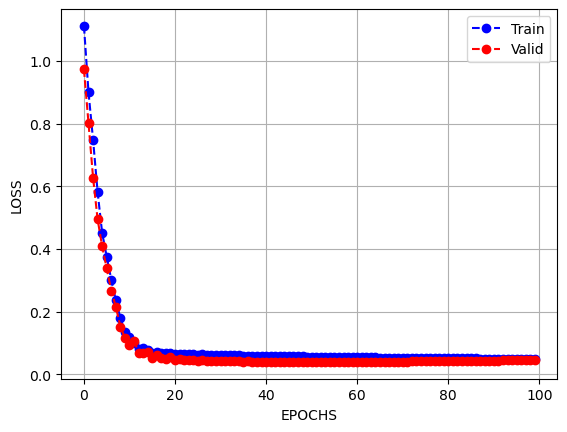

In [33]:
## 모델 성능 시각화 
import matplotlib.pyplot as plt

plt.plot(LOSS_HIST['Train'], 'bo--', label='Train')
plt.plot(LOSS_HIST['Valid'], 'ro--', label='Valid')
plt.grid()
plt.legend()
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.show()